In [1]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('C:/Users/HP/Multimodal/pre-processed/t2e/text_train.csv')
df = df.append(pd.read_csv('C:/Users/HP/Multimodal/pre-processed/t2e/text_test.csv'))
display(df.head())

C:\Users\HP\AppData\Local\Temp\ipykernel_6976\2177301214.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv('C:/Users/HP/Multimodal/pre-processed/t2e/text_test.csv'))


,wav_file,label,transcription
0,Ses04M_script02_2_M038,4,yeah ?
1,Ses03M_impro08a_F023,2,well you re not helping me at all . god this i...
2,Ses02F_impro03_M007,4,that that is the most romantic thing i have ev...
3,Ses01M_impro05_F000,5,can i help you ?
4,Ses05F_script01_2_M004,2,well so what .


In [2]:
col = ['label', 'transcription']
df = df[col]

In [3]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [4]:
df.columns = ['label', 'transcription']

In [5]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

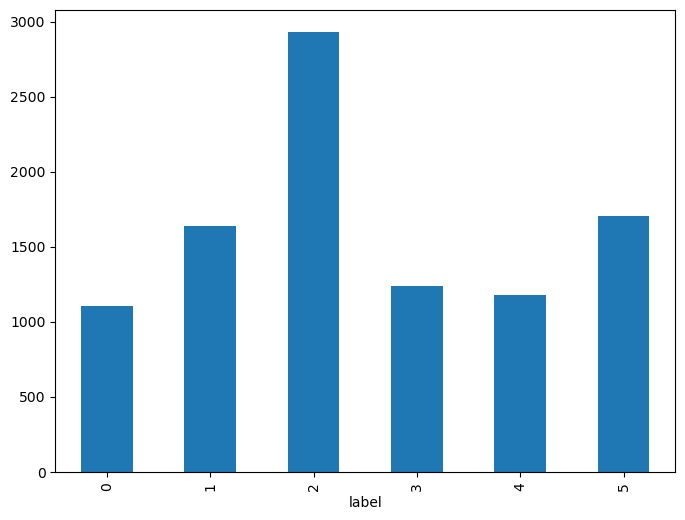

In [6]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [9]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.623
Test Set F-score =  0.614
Test Set Precision =  0.632
Test Set Recall =  0.631
Confusion matrix, without normalization
[[ 87   5  86  18  10  10]
 [  8 162  69  23  13  27]
 [ 32  39 410  39  18  64]
 [  0   0   0 249   0   0]
 [  0   0   0  40 195   0]
 [  9  48 124  37  19 119]]


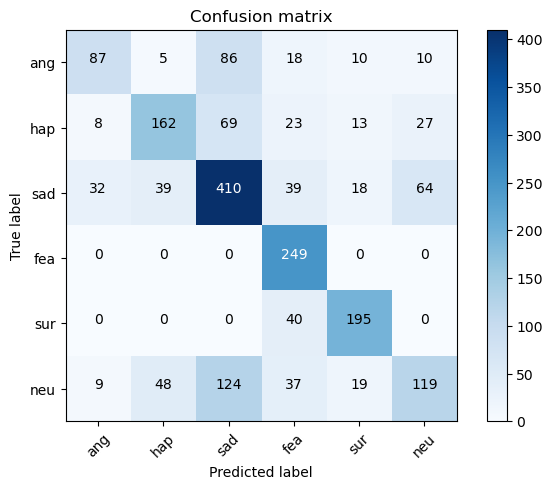

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/text/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

Test Set Accuracy =  0.561
Test Set F-score =  0.535
Test Set Precision =  0.713
Test Set Recall =  0.499
Confusion matrix, without normalization
[[ 38   4 151   0   2   4]
 [  1 112 185   8   3  21]
 [ 10  19 535   8   4  23]
 [  0   0  59 205   0   0]
 [  5   3  93   3 129   0]
 [  2  13 230   4   5  81]]


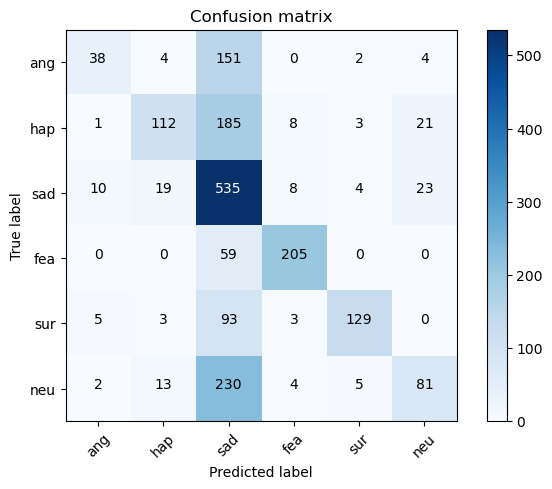

In [10]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/text/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Test Set Accuracy =  0.641
Test Set F-score =  0.634
Test Set Precision =  0.649
Test Set Recall =  0.644
Confusion matrix, without normalization
[[ 85   8  63  15   5  23]
 [  7 206  50  25   8  34]
 [ 28  36 389  52  18  76]
 [  0   0   0 264   0   0]
 [  5   3   0  46 179   0]
 [  8  48 114  22  10 133]]


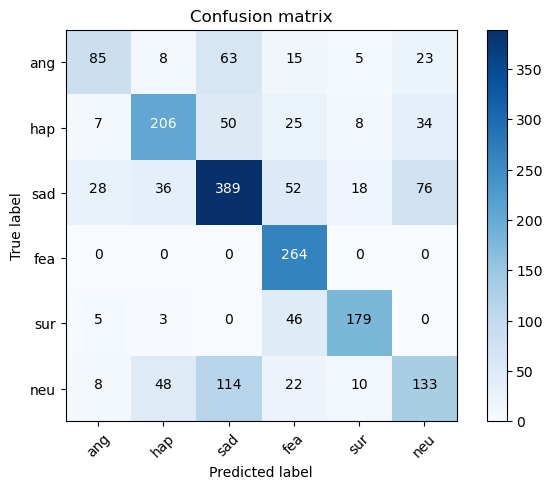

In [11]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/text/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.620
Test Set F-score =  0.618
Test Set Precision =  0.725
Test Set Recall =  0.580
Confusion matrix, without normalization
[[ 70   6  99   2   3  19]
 [  1 180 104  11   7  27]
 [ 12  20 505   8   7  47]
 [  0   0  67 197   0   0]
 [  0   3  68   3 159   0]
 [  3  29 191   6   2 104]]


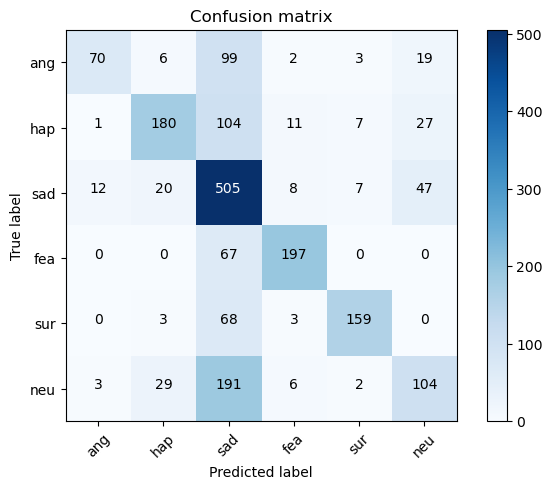

In [12]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/text/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Test Set Accuracy =  0.635
Test Set F-score =  0.632
Test Set Precision =  0.639
Test Set Recall =  0.645
Confusion matrix, without normalization
[[ 84   5  63  15   3  29]
 [  6 207  52  21  11  33]
 [ 38  36 366  52  19  88]
 [  0   0   0 264   0   0]
 [  0   0   0  46 187   0]
 [ 15  53 101  21   8 137]]


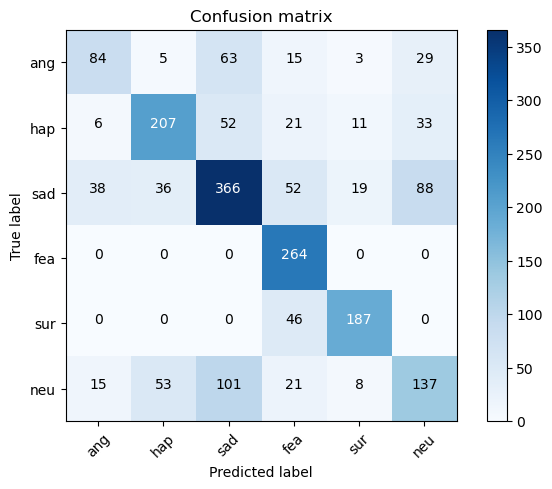

In [13]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/text/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.634
Test Set F-score =  0.637
Test Set Precision =  0.701
Test Set Recall =  0.607
Confusion matrix, without normalization
[[ 75   6  91   0   3  24]
 [  4 198  80  11   4  33]
 [ 17  30 468   9   8  67]
 [  0   0  59 205   0   0]
 [  5   6  43   3 167   9]
 [  4  43 148   5   5 130]]


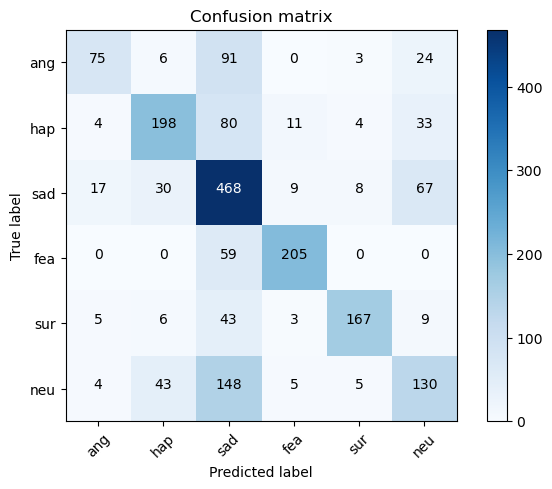

In [14]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/trained_models/text/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

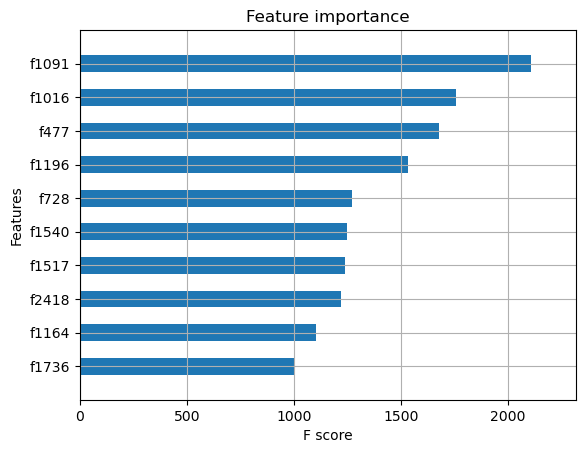

In [17]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [18]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.        , 0.        , 0.00095646, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [20]:
#with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_lstm_classifier.pkl', 'rb') as f:
    #lstm_pred_probs = pickle.load(f)
    
#display_results(y_test, lstm_pred_probs)

Test Set Accuracy =  0.619
Test Set F-score =  0.639
Test Set Precision =  0.718
Test Set Recall =  0.604
Confusion matrix, without normalization
[[102   8 100   0   5  14]
 [  5 208  91   6   7  35]
 [ 25  26 440   3  10  51]
 [  0   0  59 178   0   0]
 [  0   3  67   0 167   0]
 [  4  25 191   6   5 119]]


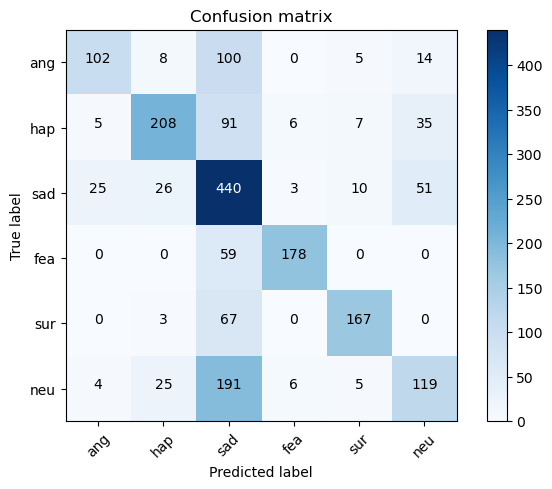

In [21]:
# Load predicted probabilities
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('C:/Users/HP/Multimodal/multimodal-speech-emotion-recognition/pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)

In [23]:
top_n = [500, 1000, 1500, 2000]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=600, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 500 features:
Test Set Accuracy =  0.533
Test Set F-score =  0.536
Test Set Precision =  0.709
Test Set Recall =  0.498
Stats for top 1000 features:
Test Set Accuracy =  0.533
Test Set F-score =  0.536
Test Set Precision =  0.709
Test Set Recall =  0.498
Stats for top 1500 features:
Test Set Accuracy =  0.533
Test Set F-score =  0.536
Test Set Precision =  0.709
Test Set Recall =  0.498
Stats for top 2000 features:
Test Set Accuracy =  0.533
Test Set F-score =  0.536
Test Set Precision =  0.709
Test Set Recall =  0.498
